In [1]:
from mc_simulation import *
import io, requests, pynucl, warnings,sys,os,logging
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

_ColormakerRegistry()

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/Align/substitution_matrices/__init__.py:21: BiopythonExperimentalWarning: Bio.Align.substitution_matrices is an experimental module which may still undergo significant changes. In particular, the location of this module may change, and the Array class defined in this module may be moved to other existing or new modules in Biopython.
  BiopythonExperimentalWarning)


### analyze fiber from static structure
#### load 1kx5 from pdb and analyze with 3dna|pynucl

In [2]:
ref_pdb='1kx5'
pdb=io.StringIO(requests.get('https://files.rcsb.org/download/%s.pdb'%(ref_pdb)).content.decode("utf-8") )
ref_1kx5=pynucl.nuclstr(pdb,format='PDB',ref="1KX5_NRF",fullseqs='1KX5',name=ref_pdb)
dna_1kx5=pynucl.a_DNA(ref_1kx5,num_threads=10)

1 frames loaded for 1kx5


In [3]:
sel=['Shear', 'Stretch', 'Stagger', 'Buckle',
       'Prop-Tw', 'Opening', 'Shift', 'Slide', 'Rise', 'Tilt', 'Roll', 'Twist']
ncp_bp_frames=np.array(list(dna_1kx5.df_series.groupby('Frame',group_keys=False).apply(lambda g: g[sel].to_numpy())))
bp_num_map=dna_1kx5.df_series[dna_1kx5.df_series.Frame==0].reset_index()[['index','BPnum_dyad']].set_index('BPnum_dyad').to_dict()['index']

In [4]:
linker=15 
N_ncp=6
ncp_bp_length=147
all_steps,positions=gen_init_fiber_par_frame_blank(ncp_bp_length,N_ncp,linker+1)

result_1kx5=to_mda_traj([positions],[[0]*N_ncp],all_steps,ncp_bp_frames,bp_num_map,mute=False)

In [5]:
result_1kx5.trajectory.dimensions_array=np.tile([1000,1000,1000,90,90,90],(len(result_1kx5.trajectory),1))
sel=result_1kx5.select_atoms('resname NUC')
bins=np.arange(10,50,0.5)
coords=result_1kx5.trajectory.timeseries(sel[0]+sel[-1],order='fac')[0]
print('End to end distance in 1kx5 fiber is', np.linalg.norm(coords[1]-coords[0]),'nm')

End to end distance in 1kx5 fiber is 21.950434 nm


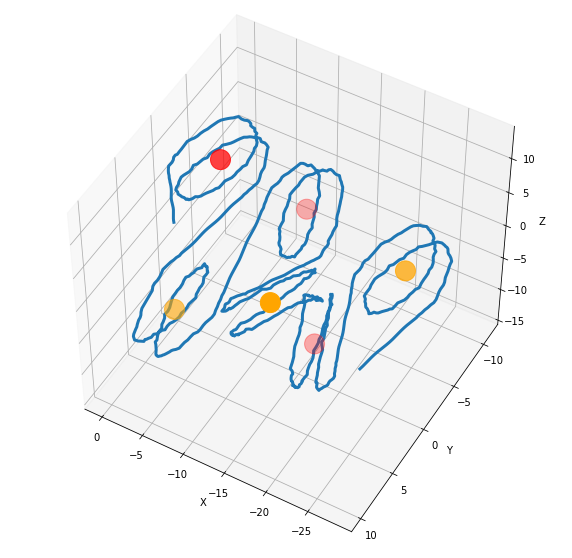

In [6]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
nuc_coords=result_1kx5.trajectory.timeseries(result_1kx5.select_atoms('resname NUC'),order='fac')[0]
dna_coords=result_1kx5.trajectory.timeseries(result_1kx5.select_atoms('resname DNA'),order='fac')[0]
ax.scatter(nuc_coords[:,0], nuc_coords[:,1], nuc_coords[:,2], marker='o',s=400,color=['red','orange']*3)
ax.plot(dna_coords[:,0], dna_coords[:,1], dna_coords[:,2],lw=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(50, 120)


plt.show()

In [15]:
import nglview as nv
view=nv.show_mdanalysis(result_1kx5)
view.add_spacefill('nuc',radius=3.5,color='red')
view

NGLWidget()

In [8]:
system='1kx5_ntm'

In [9]:
pynucl_sys=pynucl.nucltrj(f'../trj/{system}_for_web.pdb',f'../trj/{system}_for_web.xtc',time=(0,None,1),fullseqs='1KX5')

103 frames loaded for 1kx5_ntm_for_web


In [10]:
DNA=pynucl.a_DNA(pynucl_sys,num_threads=20)

In [11]:
df=DNA.df_series

In [12]:
## offsets for ncp location calculation for 1kx5
R2=np.array([[-0.9194,  0.275,   0.2815], [-0.3555, -0.2733, -0.8939], [-0.1688, -0.9218,  0.349 ]])
of_vec=np.array([44.2273, -4.1654, -0.3646])
mc_results={}
linker=15 
N_ncp=6
N_results=500

sel=['Shear', 'Stretch', 'Stagger', 'Buckle',
   'Prop-Tw', 'Opening', 'Shift', 'Slide', 'Rise', 'Tilt', 'Roll', 'Twist']
ncp_bp_frames=np.array(list(df.groupby('Frame',group_keys=False).apply(lambda g: g[sel].to_numpy())))
bp_num_map=df[df.Frame==0].reset_index()[['index','BPnum_dyad']].set_index('BPnum_dyad').to_dict()['index']



pos_traj,frame_traj,EN_traj,all_steps=simulate_MC(ncp_bp_frames,bp_num_map,
                                                      n_frames_md=len(df['Frame'].unique()),
                                                      EN_initial=2,KT=1,N_results=N_results,
                                                      init_linker_length=linker,linker_step_size=0,
                                                      N_ncp=N_ncp,Rm=60,Rm_dna=25,E_type='logistic',
                                                      MAX_mc_evals=5000)


In [13]:
# Important, to_mda_traj returns coordinates in nm!!!
mda_fiber=to_mda_traj(pos_traj,frame_traj,all_steps,ncp_bp_frames,bp_num_map,mute=False)

Text(0, 0.5, 'Probability density')

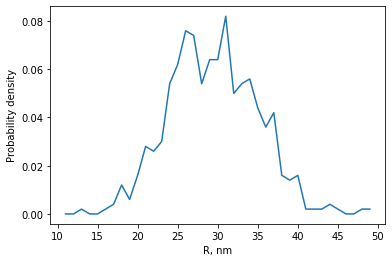

In [14]:
mda_fiber.trajectory.dimensions_array=np.tile([1000,1000,1000,90,90,90],(len(mda_fiber.trajectory),1))
sel=mda_fiber.select_atoms('resname NUC')
bins=np.arange(10,50,1)
coords=mda_fiber.trajectory.timeseries(sel[0]+sel[-1],order='fac')
corrected=np.linalg.norm(coords[:,1,:]-coords[:,0,:],axis=1)
val,edges=np.histogram(corrected,bins=bins,density=True)
plt.plot(edges[1:],val)
plt.xlabel('R, nm')
plt.ylabel('Probability density')